<h3>Total Costs Regression Model Building and Exploration</h3><br />
This notebook shows the process of building regression models for length of stay. It shows the data distribution, noramlization process, baseline performance of different regression models, a hypertuned version of the best performing model, and performance on a normalized dataset.

In [2]:
import sys
sys.path.insert(0, '../src/helpers')

from data_ingestion import *
from data_processing import *

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_ingestion.py:6: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_18 = pd.read_csv('data/raw/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2018.csv')
/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_ingestion.py:7: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_17 = pd.read_csv('data/raw/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2017.csv')


18 Dataset
['Hospital Service Area', 'Hospital County', 'Operating Certificate Number', 'Permanent Facility Id', 'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity', 'Length of Stay', 'Type of Admission', 'Patient Disposition', 'Discharge Year', 'CCSR Diagnosis Code', 'CCSR Diagnosis Description', 'CCSR Procedure Code', 'CCSR Procedure Description', 'APR DRG Code', 'APR DRG Description', 'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code', 'APR Severity of Illness Description', 'APR Risk of Mortality', 'APR Medical Surgical Description', 'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3', 'Birth Weight', 'Emergency Department Indicator', 'Total Charges', 'Total Costs'] 

17 Dataset
['Hospital Service Area', 'Hospital County', 'Operating Certificate Number', 'Permanent Facility Id', 'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity', 'Length of Stay', 'Type of Admission', 'Patient Disposition'

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_ingestion.py:19: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead.
  print(df_18.columns ^ df_17.columns, '\n')
/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_ingestion.py:37: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead.
  print(df_18.columns ^ df_17.columns, '\n')


Concatenated dataset shape:
(4696376, 34) 

Data Extracted


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_processing.py:4: DtypeWarning: Columns (14,16,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18.csv')


Overall Shape:
(4696376, 34) 

Records per year:
2018    2352807
2017    2343569
Name: Discharge Year, dtype: int64 

Columns: 
Index(['Hospital Service Area', 'Hospital County',
       'Operating Certificate Number', 'Permanent Facility Id',
       'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race',
       'Ethnicity', 'Length of Stay', 'Type of Admission',
       'Patient Disposition', 'Discharge Year', 'CCSR Diagnosis Code',
       'CCSR Diagnosis Description', 'CCSR Procedure Code',
       'CCSR Procedure Description', 'APR DRG Code', 'APR DRG Description',
       'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code',
       'APR Severity of Illness Description', 'APR Risk of Mortality',
       'APR Medical Surgical Description', 'Payment Typology 1',
       'Payment Typology 2', 'Payment Typology 3', 'Birth Weight',
       'Abortion Edit Indicator', 'Emergency Department Indicator',
       'Total Charges', 'Total Costs'],
      dtype='object') 



In [3]:
from data_cleaners import *
from model_building_helpers import *
import pandas as pd
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
all_patient_df = load_data('all')

all


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


       Hospital Service Area Hospital County  Permanent Facility Id  \
0              Hudson Valley     Westchester                 1061.0   
1              Hudson Valley     Westchester                 1061.0   
2              Hudson Valley     Westchester                 1072.0   
3              Hudson Valley        Sullivan                  971.0   
4              Hudson Valley        Sullivan                  971.0   
...                      ...             ...                    ...   
420987         New York City          Queens                 1629.0   
420988         New York City          Queens                 1629.0   
420989          Finger Lakes         Ontario                  676.0   
420990         New York City           Bronx                 3058.0   
420991         New York City           Bronx                 1169.0   

          Age Group  Gender                    Race          Ethnicity  \
0          30 to 49    Male                   White  Not Span/Hispanic   

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


<AxesSubplot:xlabel='Total Costs', ylabel='Count'>

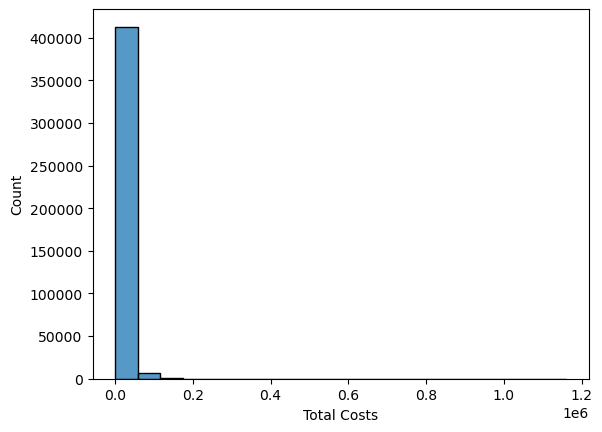

In [5]:
#Plot distibution of length of stay target variable
sns.histplot(all_patient_df['Total Costs'], bins=20, palette='orangered')

/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'Total Costs')

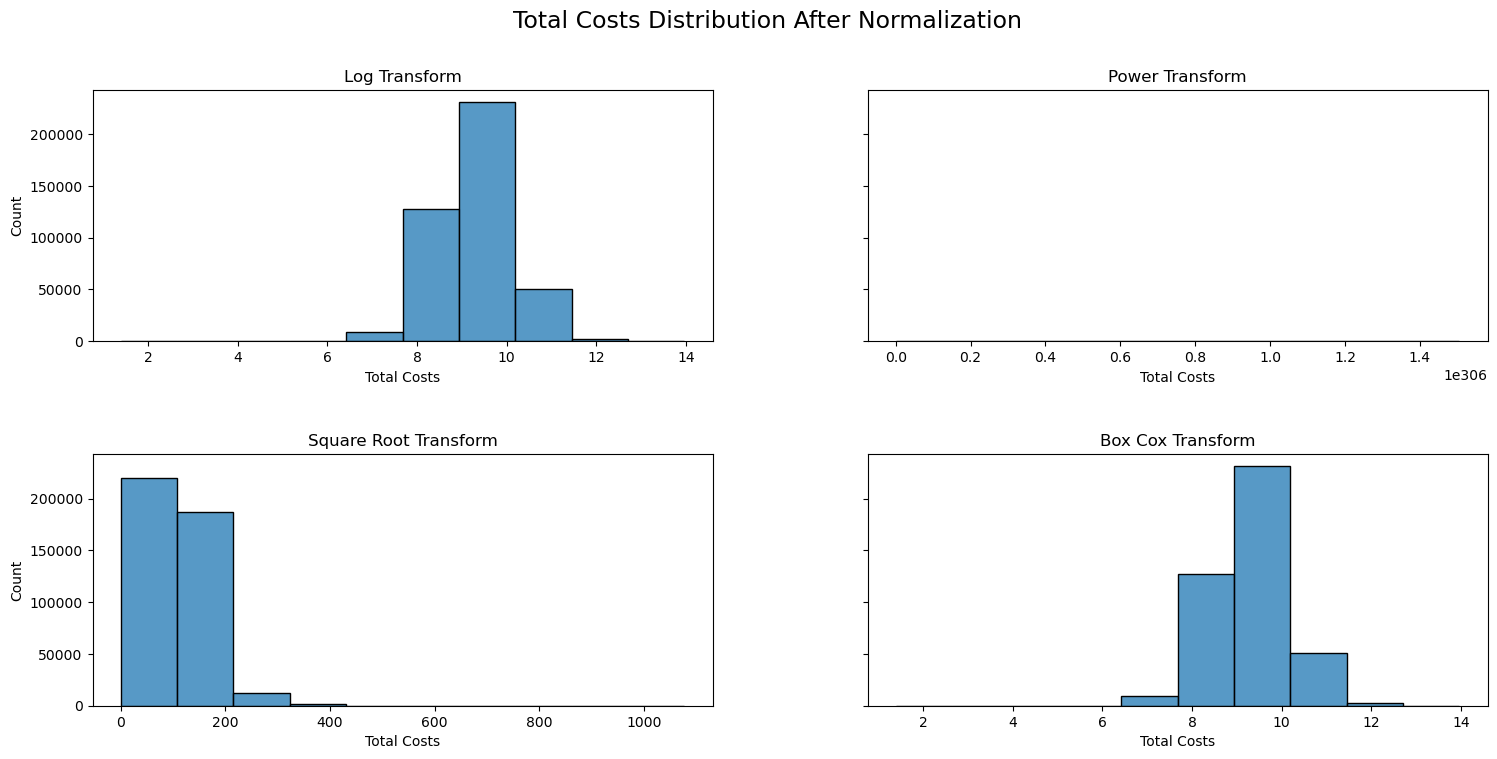

In [6]:
#Plot distibution of length of stay target variable
fig, axes = plt.subplots(2, 2, figsize=(18, 8), sharey=True)
fig.subplots_adjust(hspace=0.45, wspace=0.25)
fig.suptitle('Total Costs Distribution After Normalization', fontsize=17)

sns.histplot(ax=axes[0, 0], data=np.log(all_patient_df['Total Costs']), bins=10, palette='skyblue')
axes[0, 0].set_title('Log Transform')

sns.histplot(ax=axes[0, 1], data=np.exp(all_patient_df['Total Costs']), bins=10, palette='skyblue')
axes[0, 1].set_title('Power Transform')

sns.histplot(ax=axes[1, 0], data=np.sqrt(all_patient_df['Total Costs']), bins=10, palette='skyblue')
axes[1, 0].set_title('Square Root Transform')

sns.histplot(ax=axes[1, 1], data=stats.boxcox(all_patient_df['Total Costs'], 0), bins=10, palette='skyblue')
axes[1, 1].set_title('Box Cox Transform')
axes[1, 1].set_xlabel('Total Costs')

In [7]:
#Since training all the data takes a long time, take a stratified sample of 
# the data for initial baseline model performance testing
all_patient_stratified_sample_df = all_patient_df.groupby('Total Costs', group_keys=False).apply(
    lambda x: x.sample(int(np.rint(30000*len(x)/len(all_patient_df))))).sample(frac=1).reset_index(drop=True)

X = all_patient_stratified_sample_df.loc[:, ~all_patient_stratified_sample_df.columns.isin(['Length of Stay', 'Total Costs', 'Total Charges', 'Patient Disposition'])]
y = all_patient_stratified_sample_df[['Total Costs']]

categorical_columns = list(all_patient_stratified_sample_df.select_dtypes(include='object'))

X = pd.get_dummies(X)

X = X.loc[:, ~X.columns.isin(categorical_columns)]
y['Total Costs'] = y['Total Costs'].astype('float64')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_62314/3054294387.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Total Costs'] = y['Total Costs'].astype('float64')


In [19]:
from sklearn.model_selection import cross_validate


#Train baseline models (default parameters) on unnormalized data
models =  {
    'RidgeRegression': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'GradientBoostedRegressor': GradientBoostingRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42, n_estimators = 10) #Set this parameter so the model can run faster
}

model_scores = []


scoring = {'r2': 'r2'}

for model_key in models.keys():
    print(model_key)
    kf = StratifiedKFold(n_splits=6)
    # Perform cross-validation
    cv_scores = cross_validate(models[model_key], X, np.ravel(y), cv=kf, scoring=scoring)
    # Append the results
    model_scores.append({'Model' : model_key,
        'all_r2_scores': cv_scores['test_r2'],
        'avg_r2_score': np.mean(cv_scores['test_r2'])
    })

RidgeRegression


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


Lasso


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e+11, tolerance: 7.282e+07
  model = cd_fast.enet_coordinate_descent(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e+11, tolerance: 7.374e+07
  model = cd_fast.enet_coordinate_descent(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-pack

GradientBoostedRegressor
RandomForestRegressor


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


In [20]:
scores_df

,Model,all_r2_scores,avg_r2_score,all_mae_scores,avg_mae_score,all_mse_scores,avg_mse_score
0,RidgeRegression,"[0.3549229329451391, 0.34781534864972885, 0.34...",0.349310,"[-3786.3618689669925, -3684.473048958564, -367...",0.0,"[-23978168.12561745, -22818678.77610489, -2299...",0.0
1,Lasso,"[0.3549020285922849, 0.34749340365053794, 0.34...",0.350136,"[-3788.7237433271985, -3686.0969321367525, -36...",0.0,"[-23978945.161591742, -22829943.008565594, -23...",0.0
2,GradientBoostedRegressor,"[0.3587575714094742, 0.35445070125025113, 0.34...",0.354024,"[-3799.9361799975013, -3698.691697462937, -368...",0.0,"[-23835630.72893308, -22586520.63002765, -2285...",0.0
3,RandomForestRegressor,"[0.29657765573742156, 0.2601666414680458, 0.26...",0.287923,"[-3825.2791345837736, -3806.531822562373, -378...",0.0,"[-26146921.190440673, -25885337.413622476, -25...",0.0


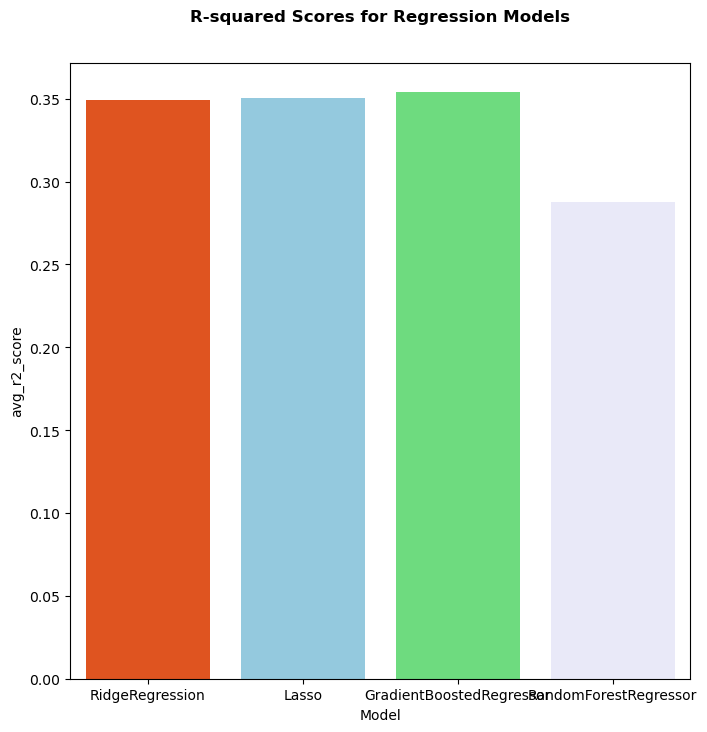

In [28]:
scores_df = pd.DataFrame(data=model_scores)

#Plot distibution of length of stay target variable
plt.figure(figsize = (8, 8))
plt.title('R-squared Scores for Regression Models', fontsize=12, weight='bold', pad=30)

sns.barplot(x=scores_df['Model'], y=scores_df['avg_r2_score'], palette=[
        'orangered', 'skyblue', '#5CED73', '#E6E6FA'])
axes.set_title('Average R2 Score')
axes.set_ylabel('Average R2 Score')
axes.set_xlabel('Model')
axes.tick_params(axis='x', rotation=90)

plt.savefig('data/visualizations/Total Costs Regression Scores (Multiple Models).png')

In [29]:
#Train models on normalized data
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import PowerTransformer

#Train baseline models (default parameters) on unnormalized data
models =  {
    'RidgeRegression': Ridge(),
    'GradientBoostedRegressor': GradientBoostingRegressor()
}

model_scores_transformed = []


scoring = {'r2': 'r2',
           'mae': 'neg_mean_absolute_error',
           'mse': 'neg_mean_squared_error'}

for model_key in models.keys():
    print(model_key)
    kf = StratifiedKFold(n_splits=6)
    # Perform cross-validation
    regr_trans = TransformedTargetRegressor(regressor=models[model_key],
                                        transformer=PowerTransformer(method='box-cox'))
    cv_scores = cross_validate(regr_trans, X, y, cv=kf, scoring=scoring)
    # Append the results
    model_scores_transformed.append({'Model' : model_key,
        'Transformation': 'Box-Cox',
        'all_r2_scores': cv_scores['test_r2'],
        'avg_r2_score': np.mean(cv_scores['test_r2']),
        'all_mae_scores': cv_scores['test_mae'],
        'avg_mae_score': np.mean(cv_scores['test_mae']),
        'all_mse_scores': cv_scores['test_mse'],
        'avg_mse_score': np.mean(cv_scores['test_mse'])
    })

for model_key in models.keys():
    print(model_key)
    kf = StratifiedKFold(n_splits=6)
    # Perform cross-validation
    regr_trans = TransformedTargetRegressor(regressor=models[model_key],
                                        func=np.log, inverse_func=np.exp)
    cv_scores = cross_validate(regr_trans, X, y, cv=kf, scoring=scoring)
    # Append the results
    model_scores_transformed.append({'Model' : model_key,
        'Transformation': 'Log Transform',
        'all_r2_scores': cv_scores['test_r2'],
        'avg_r2_score': np.mean(cv_scores['test_r2']),
        'all_mae_scores': cv_scores['test_mae'],
        'avg_mae_score': np.mean(cv_scores['test_mae']),
        'all_mse_scores': cv_scores['test_mse'],
        'avg_mse_score': np.mean(cv_scores['test_mse'])
    })

for model_key in models.keys():
    print(model_key)
    kf = StratifiedKFold(n_splits=6)
    # Perform cross-validation
    regr_trans = TransformedTargetRegressor(regressor=models[model_key],
                                        func=np.sqrt, inverse_func=np.square)
    cv_scores = cross_validate(regr_trans, X, y, cv=kf, scoring=scoring)
    # Append the results
    model_scores_transformed.append({'Model' : model_key,
        'Transformation': 'Square Root',
        'all_r2_scores': cv_scores['test_r2'],
        'avg_r2_score': np.mean(cv_scores['test_r2']),
        'all_mae_scores': cv_scores['test_mae'],
        'avg_mae_score': np.mean(cv_scores['test_mae']),
        'all_mse_scores': cv_scores['test_mse'],
        'avg_mse_score': np.mean(cv_scores['test_mse'])
    })

RidgeRegression


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


GradientBoostedRegressor


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


RidgeRegression


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


GradientBoostedRegressor


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


RidgeRegression


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


GradientBoostedRegressor


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


[Text(0, 0, '0.331517'), Text(0, 0, '0.334598')]

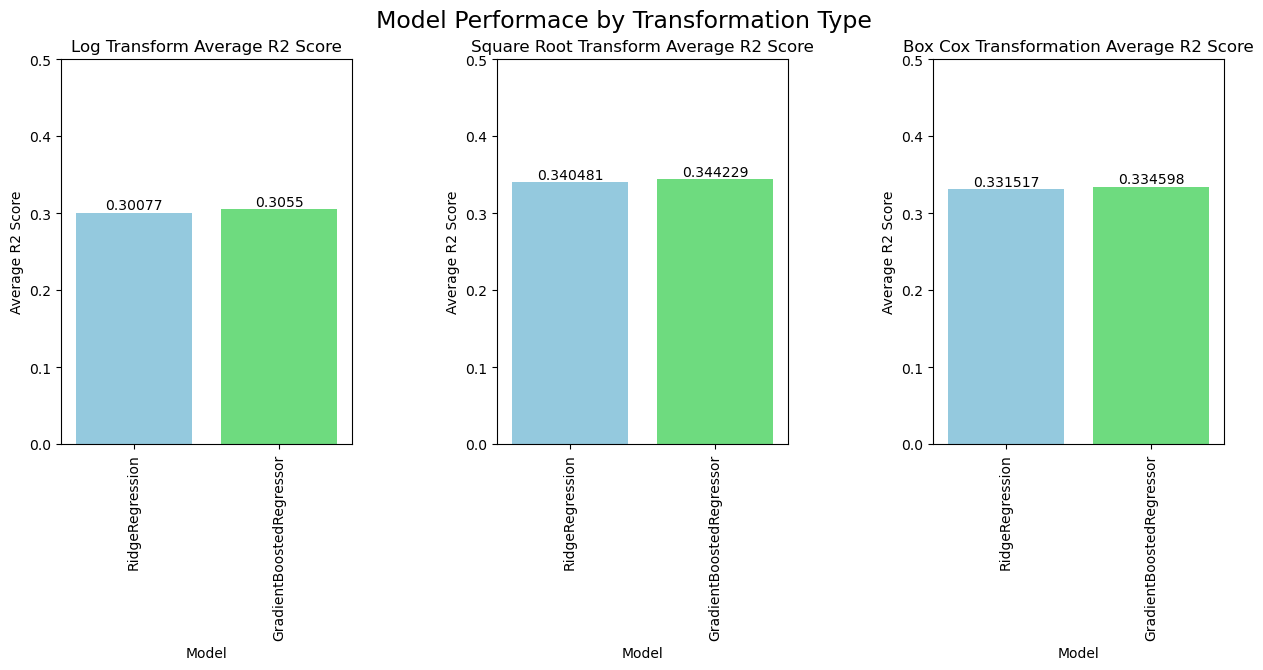

In [34]:
model_scores_transformed_df = pd.DataFrame(data=model_scores_transformed)

log_transform_df = model_scores_transformed_df[model_scores_transformed_df['Transformation'] == 'Log Transform']
sqrt_df = model_scores_transformed_df[model_scores_transformed_df['Transformation'] == 'Square Root']
box_cox_df = model_scores_transformed_df[model_scores_transformed_df['Transformation'] == 'Box-Cox']

color_values = ['skyblue', '#5CED73']

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.subplots_adjust(hspace=0.95, wspace=0.50)
fig.suptitle('Model Performace by Transformation Type', fontsize=17)

sns.barplot(ax=axes[0], x=log_transform_df['Model'], y=np.absolute(log_transform_df['avg_r2_score']), palette = color_values)
axes[0].set_title('Log Transform Average R2 Score')
axes[0].set_ylabel('Average R2 Score')
axes[0].set_xlabel('Model')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_ylim(0, 0.5)
axes[0].bar_label(axes[0].containers[0])

sns.barplot(ax=axes[1], x=sqrt_df['Model'], y=np.absolute(sqrt_df['avg_r2_score']), palette = color_values)
axes[1].set_title('Square Root Transform Average R2 Score')
axes[1].set_ylabel('Average R2 Score')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_ylim(0, 0.5)
axes[1].bar_label(axes[1].containers[0])

sns.barplot(ax=axes[2], x=box_cox_df['Model'], y=np.absolute(box_cox_df['avg_r2_score']), palette = color_values)
axes[2].set_title('Box Cox Transformation Average R2 Score')
axes[2].set_ylabel('Average R2 Score')
axes[2].set_xlabel('Model')
axes[2].tick_params(axis='x', rotation=90)
axes[2].set_ylim(0, 0.5)
axes[2].bar_label(axes[2].containers[0])



In [36]:
params = {
    'regressor__n_estimators': [10, 50, 100, 500],
    'regressor__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'regressor__subsample': [0.5, 0.7, 1.0],
    'regressor__max_depth': [1, 3, 7, 9, 10]
}

grid_search = RandomizedSearchCV(estimator = TransformedTargetRegressor(regressor=GradientBoostingRegressor(random_state=42), func=np.sqrt, inverse_func=np.square), param_distributions=params, 
                      cv = StratifiedKFold(n_splits=3), n_iter=20, n_jobs = -1, verbose = 2, scoring='r2')

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


{'regressor__subsample': 0.7, 'regressor__n_estimators': 500, 'regressor__max_depth': 9, 'regressor__learning_rate': 0.01}
0.3894643786195264


In [40]:
regr_trans = TransformedTargetRegressor(regressor=GradientBoostingRegressor(learning_rate = 0.01, 
                                                                            max_depth = 9, 
                                                                            n_estimators = 500, 
                                                                            subsample = 0.7),
                                        transformer=PowerTransformer(method='box-cox'))
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)
print('=================================================================================================================')
print("R2 Score = ", r2_score(y_test, y_pred), "Mean Absolute Error (MAE) = ", mean_absolute_error(y_test, y_pred), "Mean Squared Error (MSE) = ", mean_squared_error(y_test, y_pred))
print('=================================================================================================================')

R2 Score =  0.38899570994779886 Mean Absolute Error (MAE) =  3446.258547940548 Mean Squared Error (MSE) =  21688598.97742553


In [41]:
data={'feature_names':regr_trans.regressor_.feature_names_in_,'feature_importance':regr_trans.regressor_.feature_importances_}
features_importance_df = pd.DataFrame(data)
features_importance_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
features_importance_df.head()
feature_importance_to_20_df = features_importance_df[0:20]

[Text(2, 0, '0.208'),
 Text(2, 0, '0.091'),
 Text(2, 0, '0.078'),
 Text(2, 0, '0.073'),
 Text(2, 0, '0.055'),
 Text(2, 0, '0.033'),
 Text(2, 0, '0.028'),
 Text(2, 0, '0.026'),
 Text(2, 0, '0.023'),
 Text(2, 0, '0.014'),
 Text(2, 0, '0.013'),
 Text(2, 0, '0.012'),
 Text(2, 0, '0.012'),
 Text(2, 0, '0.011'),
 Text(2, 0, '0.011'),
 Text(2, 0, '0.010'),
 Text(2, 0, '0.007'),
 Text(2, 0, '0.007'),
 Text(2, 0, '0.007'),
 Text(2, 0, '0.007')]

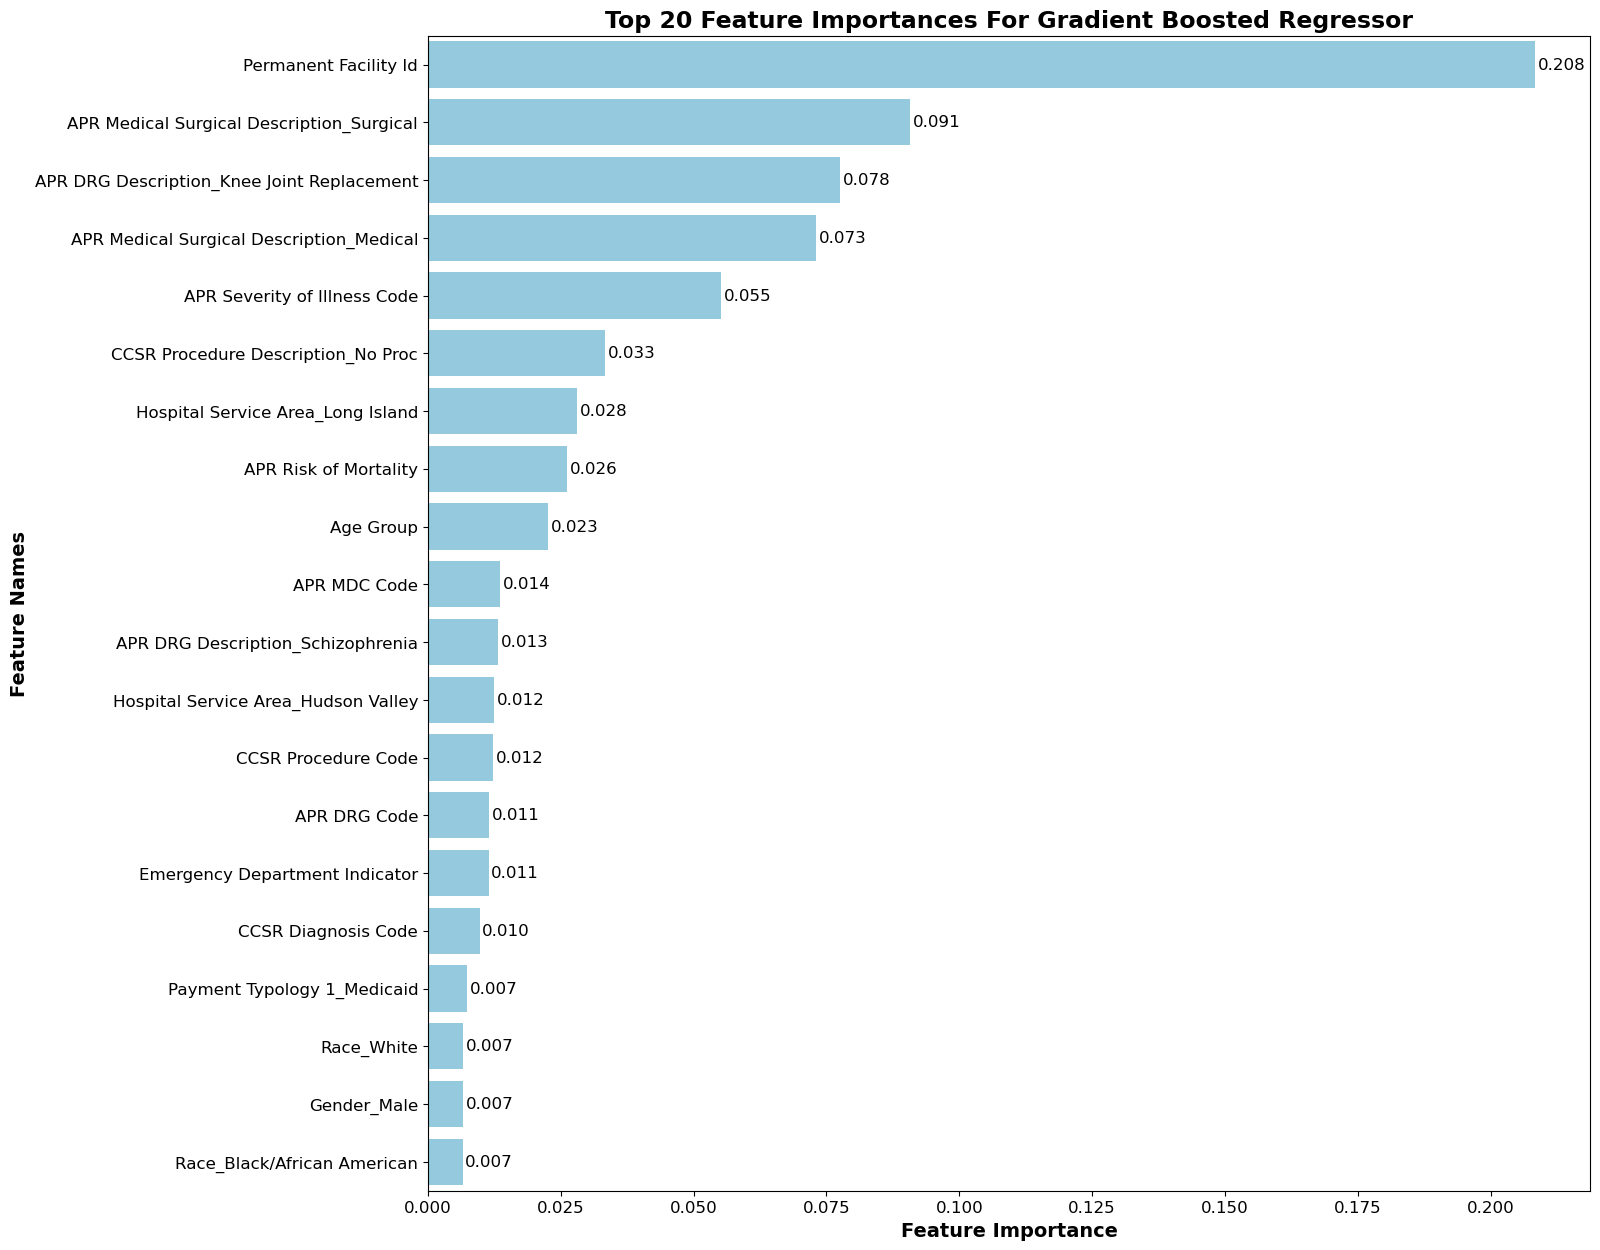

[CV] END regressor__learning_rate=0.01, regressor__max_depth=7, regressor__n_estimators=50, regressor__subsample=1.0; total time=   6.1s
[CV] END regressor__learning_rate=0.0001, regressor__max_depth=10, regressor__n_estimators=100, regressor__subsample=0.5; total time=   7.8s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=9, regressor__n_estimators=50, regressor__subsample=1.0; total time=   6.4s
[CV] END regressor__learning_rate=1.0, regressor__max_depth=9, regressor__n_estimators=100, regressor__subsample=0.7; total time=  10.1s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=500, regressor__subsample=1.0; total time=  25.7s
[CV] END regressor__learning_rate=1.0, regressor__max_depth=10, regressor__n_estimators=100, regressor__subsample=0.5; total time=   9.4s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=9, regressor__n_estimators=50, regressor__subsample=0.5; total time=   3.4s
[CV] END regressor__learning_rate=0.

In [42]:
plt.figure(figsize=(15,15))

sns_barplot = sns.barplot(x=feature_importance_to_20_df['feature_importance'], y=feature_importance_to_20_df['feature_names'], palette = ['skyblue'])
plt.xlabel('Feature Importance', fontsize=14, fontweight='bold')
plt.ylabel('Feature Names', fontsize=14, fontweight='bold')
plt.title('Top 20 Feature Importances For Gradient Boosted Regressor', fontsize=17, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.bar_label(sns_barplot.containers[0], fmt='%.3f', padding=2, fontsize=12)